In [1]:
import os
import numpy as np
from skimage import io
from matplotlib import pyplot as plt
from scipy.misc import imresize
from scipy import ndimage

%matplotlib inline

import tensorflow as tf
from keras.layers import Dense, Activation, Flatten, Lambda, BatchNormalization, Reshape, Dropout
from keras.layers import Convolution2D, MaxPooling2D, AveragePooling2D, UpSampling2D, ZeroPadding2D
from keras.engine import merge, Input, Model
from keras.optimizers import SGD
from keras.callbacks import Callback, LearningRateScheduler, ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
import keras.backend as K
import time
import random
import pickle
import json
import csv
from tqdm import tqdm
from natsort import natsorted

from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

from helper import to_rle
from segmentation import *
from stochastic_depth_resnet import *
from inception_v4 import *
from inception_resnet_v2 import *

DATADIR = os.path.expanduser('~/data/kaggle/ultrasound-nerve-segmentation')
PROCDIR = os.path.expanduser('~/ml/kaggle/ultrasound-nerve-segmentation/processed')
MODELDIR = os.path.expanduser('~/ml/kaggle/ultrasound-nerve-segmentation/models')
SUBMITDIR = os.path.expanduser('~/ml/kaggle/ultrasound-nerve-segmentation/submissions')

Using TensorFlow backend.


In [2]:
WEIGHTS_PRESENCE_A_FILEPATH = os.path.join(MODELDIR, 'model-07a-presence-weights.hdf5')
HISTORY_PRESENCE_A_FILEPATH = os.path.join(MODELDIR, 'model-07a-presence-training-history.json')
WEIGHTS_PRESENCE_B_FILEPATH = os.path.join(MODELDIR, 'model-07b-presence-weights.hdf5')
HISTORY_PRESENCE_B_FILEPATH = os.path.join(MODELDIR, 'model-07b-presence-training-history.json')
WEIGHTS_PRESENCE_C_FILEPATH = os.path.join(MODELDIR, 'model-07c-presence-weights.hdf5')
HISTORY_PRESENCE_C_FILEPATH = os.path.join(MODELDIR, 'model-07c-presence-training-history.json')

WEIGHTS_SEGMENT_FILEPATH = os.path.join(MODELDIR, 'model-08-segment-weights.hdf5')
HISTORY_SEGMENT_FILEPATH = os.path.join(MODELDIR, 'model-08-segment-training-history.json')

In [3]:
with open(os.path.join(PROCDIR, 'train_files_map.pkl'), 'rb') as f:
    train_files_map = pickle.load(f)
with open(os.path.join(PROCDIR, 'test_files_map.pkl'), 'rb') as f:
    test_files_map = pickle.load(f)

In [4]:
with open(os.path.join(PROCDIR, 'data_train_val_08.pkl'), 'rb') as f:
    (data_images_all_train, data_images_all_val, 
     data_presence_train, data_presence_val, 
     data_images_pos_train, data_images_pos_val, 
     data_masks_pos_train, data_masks_pos_val) = pickle.load(f)

print('image (all) shapes:', data_images_all_train.shape, data_images_all_val.shape)
print('presence label shapes:', data_presence_train.shape, data_presence_val.shape)
print('image (pos) shapes:', data_images_pos_train.shape, data_images_pos_val.shape)
print('mask (pos) shapes:', data_masks_pos_train.shape, data_masks_pos_val.shape)

image (all) shapes: (22775, 128, 192, 1) (1080, 128, 192, 1)
presence label shapes: (22775,) (1080,)
image (pos) shapes: (9355, 128, 192, 1) (452, 128, 192, 1)
mask (pos) shapes: (9355, 128, 192) (452, 128, 192)


## presence model a

In [7]:
with tf.device('/gpu:0'):
    
    start_time = time.time()

    orig_img_rows, orig_img_cols = 420, 580
    img_rows_presence, img_cols_presence = 64, 96
    img_channels = 1

    blocks_per_group = 3
    nb_total_blocks = 5 * blocks_per_group
    
    images_presence_a = Input(shape=(img_rows_presence, img_cols_presence, img_channels))

    x_a = Convolution2D(4, 3, 3, subsample=(1, 1),
                      init='he_normal', border_mode='same', dim_ordering='tf')(images_presence_a)
    x_a = BatchNormalization(axis=3)(x_a)
    x_a = Activation('relu')(x_a)

    for i in range(0, blocks_per_group):
        nb_filters = 4
        x_a = stochastic_depth_residual_block(x_a, nb_filters=nb_filters,
                                            block=i, nb_total_blocks=nb_total_blocks,
                                            subsample_factor=1)

    for i in range(0, blocks_per_group):
        nb_filters = 8
        if i == 0:
            subsample_factor = 2
        else:
            subsample_factor = 1
        x_a = stochastic_depth_residual_block(x_a, nb_filters=nb_filters,
                                            block=blocks_per_group + i, nb_total_blocks=nb_total_blocks,
                                            subsample_factor=subsample_factor)

    for i in range(0, blocks_per_group):
        nb_filters = 16
        if i == 0:
            subsample_factor = 2
        else:
            subsample_factor = 1
        x_a = stochastic_depth_residual_block(x_a, nb_filters=nb_filters,
                                            block=2 * blocks_per_group + i, nb_total_blocks=nb_total_blocks,
                                            subsample_factor=subsample_factor)

    for i in range(0, blocks_per_group):
        nb_filters = 32
        if i == 0:
            subsample_factor = 2
        else:
            subsample_factor = 1
        x_a = stochastic_depth_residual_block(x_a, nb_filters=nb_filters,
                                            block=3 * blocks_per_group + i, nb_total_blocks=nb_total_blocks,
                                            subsample_factor=subsample_factor)

    for i in range(0, blocks_per_group):
        nb_filters = 64
        if i == 0:
            subsample_factor = 2
        else:
            subsample_factor = 1
        x_a = stochastic_depth_residual_block(x_a, nb_filters=nb_filters,
                                            block=4 * blocks_per_group + i, nb_total_blocks=nb_total_blocks,
                                            subsample_factor=subsample_factor)

    x_a = AveragePooling2D(pool_size=(4, 6), strides=None, border_mode='valid', dim_ordering='tf')(x_a)
    x_a = Dropout(0.5)(x_a)
    x_a = Flatten()(x_a)
    presence_a = Dense(1, activation='sigmoid')(x_a)

    model_presence_a = Model(input=images_presence_a, output=presence_a)

    print('model init time: {}'.format(time.time() - start_time))

    start_time = time.time()

    model_presence_a.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    print('model compile time: {}'.format(time.time() - start_time))

model init time: 5.7967329025268555
model compile time: 2.1178181171417236


## presence model a train

In [ ]:
with tf.device('/gpu:0'):
    batch_size = 128
    nb_epoch = 1
    history = model_presence_a.fit(data_images_all_train, data_presence_train,
                                   batch_size=batch_size, nb_epoch=nb_epoch, verbose=1,
                                   validation_data=(data_images_all_val, data_presence_val), shuffle=True,
                                   callbacks=[])

## presence model b

In [5]:
with tf.device('/gpu:0'):
    
    start_time = time.time()

    orig_img_rows, orig_img_cols = 420, 580
    img_rows_presence, img_cols_presence = 64, 96
    img_channels = 1

    nb_filters_reduction_factor = 8
    
    # in original inception-v4, these are 4, 7, 3, respectively
    num_A_blocks = 1
    num_B_blocks = 2
    num_C_blocks = 1
    
    images_presence_b = Input(shape=(img_rows_presence, img_cols_presence, img_channels))

    x_b = inception_v4_stem(images_presence_b, nb_filters_reduction_factor=nb_filters_reduction_factor)
    for i in range(num_A_blocks):
        x_b = inception_v4_A(x_b, nb_filters_reduction_factor=nb_filters_reduction_factor)
    x_b = inception_v4_reduction_A(x_b, nb_filters_reduction_factor=nb_filters_reduction_factor)
    for i in range(num_B_blocks):
        x_b = inception_v4_B(x_b, nb_filters_reduction_factor=nb_filters_reduction_factor)
    x_b = inception_v4_reduction_B(x_b, nb_filters_reduction_factor=nb_filters_reduction_factor)
    for i in range(num_C_blocks):
        x_b = inception_v4_C(x_b, nb_filters_reduction_factor=nb_filters_reduction_factor)

    x_b = AveragePooling2D(pool_size=(4, 6), strides=(1, 1), border_mode='valid', dim_ordering='tf')(x_b)
    x_b = Dropout(0.5)(x_b)
    x_b = Flatten()(x_b)
    presence_b = Dense(1, activation='sigmoid')(x_b)

    model_presence_b = Model(input=images_presence_b, output=presence_b)

    print('model init time: {}'.format(time.time() - start_time))

    start_time = time.time()

    model_presence_b.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    print('model compile time: {}'.format(time.time() - start_time))

model init time: 3.070420503616333
model compile time: 0.5876097679138184


## presence model b train

In [ ]:
with tf.device('/gpu:0'):
    batch_size = 72
    nb_epoch = 1
    history = model_presence_b.fit(data_images_all_train, data_presence_train,
                                   batch_size=batch_size, nb_epoch=nb_epoch, verbose=1,
                                   validation_data=(data_images_all_val, data_presence_val), shuffle=True,
                                   callbacks=[])

## presence model c

In [10]:
with tf.device('/gpu:0'):
    
    start_time = time.time()

    orig_img_rows, orig_img_cols = 420, 580
    img_rows_presence, img_cols_presence = 64, 96
    img_channels = 1

    nb_filters_reduction_factor = 8
    
    # in original inception-resnet-v2, these are 5, 10, 5, respectively
    num_A_blocks = 1
    num_B_blocks = 2
    num_C_blocks = 1
    
    images_presence_c = Input(shape=(img_rows_presence, img_cols_presence, img_channels))

    x_c = inception_resnet_v2_stem(images_presence_c, nb_filters_reduction_factor=nb_filters_reduction_factor)
    for i in range(num_A_blocks):
        x_c = inception_resnet_v2_A(x_c, nb_filters_reduction_factor=nb_filters_reduction_factor)
    x_c = inception_resnet_v2_reduction_A(x_c, nb_filters_reduction_factor=nb_filters_reduction_factor)
    for i in range(num_B_blocks):
        x_c = inception_resnet_v2_B(x_c, nb_filters_reduction_factor=nb_filters_reduction_factor)
    x_c = inception_resnet_v2_reduction_B(x_c, nb_filters_reduction_factor=nb_filters_reduction_factor)
    for i in range(num_C_blocks):
        x_c = inception_resnet_v2_C(x_c, nb_filters_reduction_factor=nb_filters_reduction_factor)

    x_c = AveragePooling2D(pool_size=(4, 6), strides=(1, 1), border_mode='valid', dim_ordering='tf')(x_c)
    x_c = Dropout(0.5)(x_c)
    x_c = Flatten()(x_c)
    presence_c = Dense(1, activation='sigmoid')(x_c)

    model_presence_c = Model(input=images_presence_c, output=presence_c)

    print('model init time: {}'.format(time.time() - start_time))

    start_time = time.time()

    model_presence_c.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    print('model compile time: {}'.format(time.time() - start_time))

model init time: 10.04953908920288
model compile time: 1.1898224353790283


## presence model c train

In [ ]:
with tf.device('/gpu:0'):
    batch_size = 72
    nb_epoch = 3
    history = model_presence_c.fit(data_images_all_train, data_presence_train,
                                   batch_size=batch_size, nb_epoch=nb_epoch, verbose=1,
                                   validation_data=(data_images_all_val, data_presence_val), shuffle=True,
                                   callbacks=[])

## segmentation model

In [9]:
with tf.device('/gpu:1'):
    
    start_time = time.time()

    orig_img_rows, orig_img_cols = 420, 580
    img_rows_segment, img_cols_segment = 128, 192
    img_channels = 1

    blocks_per_group = 4
    nb_total_blocks = 5 * blocks_per_group

    images_segment = Input(shape=(img_rows_segment, img_cols_segment, img_channels))

    x = Convolution2D(8, 3, 3, subsample=(1, 1),
                      init='he_normal', border_mode='same', dim_ordering='tf')(images_segment)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)

    for i in range(0, blocks_per_group):
        nb_filters = 8
        x = stochastic_depth_residual_block(x, nb_filters=nb_filters,
                                            block=i, nb_total_blocks=nb_total_blocks,
                                            subsample_factor=1)

    for i in range(0, blocks_per_group):
        nb_filters = 16
        if i == 0:
            subsample_factor = 2
        else:
            subsample_factor = 1
        x = stochastic_depth_residual_block(x, nb_filters=nb_filters,
                                            block=blocks_per_group + i, nb_total_blocks=nb_total_blocks,
                                            subsample_factor=subsample_factor)

    f2 = x
    f2 = UpSampling2D(size=(2, 2), dim_ordering='tf')(f2)
    f2 = Convolution2D(8, 3, 3, init='he_uniform', border_mode='same', activation='relu', dim_ordering='tf')(f2)

    for i in range(0, blocks_per_group):
        nb_filters = 32
        if i == 0:
            subsample_factor = 2
        else:
            subsample_factor = 1
        x = stochastic_depth_residual_block(x, nb_filters=nb_filters,
                                            block=2 * blocks_per_group + i, nb_total_blocks=nb_total_blocks,
                                            subsample_factor=subsample_factor)

    f4 = x
    f4 = UpSampling2D(size=(4, 4), dim_ordering='tf')(f4)
    f4 = Convolution2D(8, 3, 3, init='he_uniform', border_mode='same', activation='relu', dim_ordering='tf')(f4)

    for i in range(0, blocks_per_group):
        nb_filters = 64
        if i == 0:
            subsample_factor = 2
        else:
            subsample_factor = 1
        x = stochastic_depth_residual_block(x, nb_filters=nb_filters,
                                            block=3 * blocks_per_group + i, nb_total_blocks=nb_total_blocks,
                                            subsample_factor=subsample_factor)

    f8 = x
    f8 = UpSampling2D(size=(8, 8), dim_ordering='tf')(f8)
    f8 = Convolution2D(8, 3, 3, init='he_uniform', border_mode='same', activation='relu', dim_ordering='tf')(f8)

    for i in range(0, blocks_per_group):
        nb_filters = 64
        if i == 0:
            subsample_factor = 2
        else:
            subsample_factor = 1
        x = stochastic_depth_residual_block(x, nb_filters=nb_filters,
                                            block=4 * blocks_per_group + i, nb_total_blocks=nb_total_blocks,
                                            subsample_factor=subsample_factor)

    f16 = x
    f16 = UpSampling2D(size=(16, 16), dim_ordering='tf')(f16)
    f16 = Convolution2D(8, 3, 3, init='he_uniform', border_mode='same', activation='relu', dim_ordering='tf')(f16)

    segmentation = merge([f16, f8, f4, f2], mode='concat', concat_axis=-1)
    segmentation = Convolution2D(1, 1, 1,
                                 activation='sigmoid',
                                 init='uniform', border_mode='same', dim_ordering='tf')(segmentation)
    segmentation = Reshape((img_rows_segment, img_cols_segment))(segmentation)

    model_segment = Model(input=images_segment, output=segmentation)

    print('model init time: {}'.format(time.time() - start_time))

    start_time = time.time()

    model_segment.compile(optimizer='adam', loss=binaryCE, metrics=[dice_coeff])

    print('model compile time: {}'.format(time.time() - start_time))

model init time: 19.909674406051636
model compile time: 3.249070405960083


## segmentation model train

In [ ]:
with tf.device('/gpu:1'):
    batch_size = 64
    nb_epoch = 1
    history = model_segment.fit(data_images_pos_train, data_masks_pos_train,
                                  batch_size=batch_size, nb_epoch=nb_epoch, verbose=1,
                                  validation_data=(data_images_pos_val, data_masks_pos_val), shuffle=True,
                                  callbacks=[])

## test

In [8]:
with tf.device('/gpu:0'):
    model_presence_a.load_weights(WEIGHTS_PRESENCE_A_FILEPATH)
    model_presence_b.load_weights(WEIGHTS_PRESENCE_B_FILEPATH)
    #model_presence_c.load_weights(WEIGHTS_PRESENCE_C_FILEPATH)

In [10]:
with tf.device('/gpu:1'):
    model_segment.load_weights(WEIGHTS_SEGMENT_FILEPATH)

presence prediction a:  [ 0.88464767] [ True]
presence prediction b:  [ 0.98702115] [ True]
presence prediction (combined):  0.935834407806 True


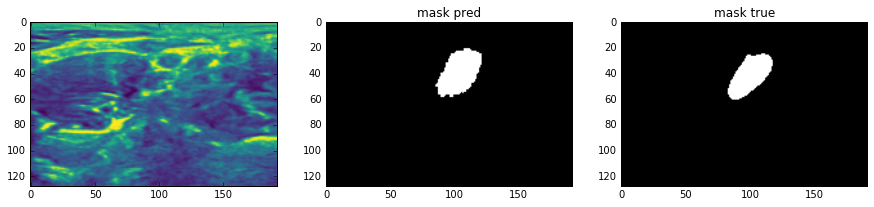

In [23]:
rand_i = random.randint(0, data_images_pos_val.shape[0] - 1)

image = data_images_pos_val[rand_i:rand_i+1]
image_presence = np.expand_dims(np.expand_dims(imresize(image[0,:,:,0], size=(img_rows_presence, img_cols_presence), interp='bilinear'), axis=0), axis=3)
mask = data_masks_pos_val[rand_i, :, :]

presence_a = model_presence_a.predict(image_presence, verbose=0)[0]
presence_b = model_presence_b.predict(image_presence, verbose=0)[0]
#presence_c = model_presence_c.predict(image_presence, verbose=0)[0]
print('presence prediction a: ', presence_a, presence_a > 0.5)
print('presence prediction b: ', presence_b, presence_b > 0.5)
#print('presence prediction c: ', presence_c, presence_c > 0.5)
presence = np.mean([presence_a, presence_b])
print('presence prediction (combined): ', presence, presence > 0.5)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(image[0,:,:,0], cmap=plt.cm.viridis)
plt.subplot(1,3,2)
plt.title('mask pred')
plt.imshow(model_segment.predict(image, verbose=0)[0, :, :] > 0.5, cmap=plt.cm.bone)
plt.subplot(1,3,3)
plt.title('mask true')
plt.imshow(mask, cmap=plt.cm.bone)

In [24]:
# presence classification metrics
images_resized = []
for i in range(data_images_all_val.shape[0]):
    images_resized.append(np.expand_dims(imresize(data_images_all_val[i,:,:,0], size=(img_rows_presence, img_cols_presence), interp='bilinear'), axis=2))
images_resized = np.array(images_resized, dtype=np.float32)
presence_a = model_presence_a.predict(images_resized, verbose=0)
presence_b = model_presence_b.predict(images_resized, verbose=0)
print('presence model a')
print('confusion matrix:\n', confusion_matrix(data_presence_val, presence_a > 0.5), '\n')
print('ROC AUC: ', roc_auc_score(data_presence_val, presence_a), '\n')
print(classification_report(data_presence_val, presence_a > 0.5, target_names=['BP not present', 'BP present']), '\n')
print('presence model b')
print('confusion matrix:\n', confusion_matrix(data_presence_val, presence_b > 0.5), '\n')
print('ROC AUC: ', roc_auc_score(data_presence_val, presence_b), '\n')
print(classification_report(data_presence_val, presence_b > 0.5, target_names=['BP not present', 'BP present']), '\n')
print('presence model (combined)')
presence = (presence_a + presence_b) / 2
print('confusion matrix:\n', confusion_matrix(data_presence_val, presence > 0.5), '\n')
print('ROC AUC: ', roc_auc_score(data_presence_val, presence), '\n')
print(classification_report(data_presence_val, presence > 0.5, target_names=['BP not present', 'BP present']), '\n')

presence model a
confusion matrix:
 [[535  93]
 [184 268]] 

ROC AUC:  0.81616735246 

                precision    recall  f1-score   support

BP not present       0.74      0.85      0.79       628
    BP present       0.74      0.59      0.66       452

   avg / total       0.74      0.74      0.74      1080
 

presence model b
confusion matrix:
 [[502 126]
 [ 75 377]] 

ROC AUC:  0.895573812074 

                precision    recall  f1-score   support

BP not present       0.87      0.80      0.83       628
    BP present       0.75      0.83      0.79       452

   avg / total       0.82      0.81      0.81      1080
 

presence model (combined)
confusion matrix:
 [[511 117]
 [101 351]] 

ROC AUC:  0.881397610056 

                precision    recall  f1-score   support

BP not present       0.83      0.81      0.82       628
    BP present       0.75      0.78      0.76       452

   avg / total       0.80      0.80      0.80      1080
 



In [25]:
preds_segment = model_segment.predict(data_images_pos_val, verbose=0)
np.mean(2 * np.sum(data_masks_pos_val * preds_segment>0.5) / (np.sum(data_masks_pos_val) + np.sum(preds_segment>0.5) + 1e-6), axis=None)

0.78859763392158899

In [90]:
images_resized = []
for i in range(data_images_val.shape[0]):
    images_resized.append(np.expand_dims(imresize(data_images_val[i,:,:,0], size=(img_rows, img_cols), interp='bilinear'), axis=2))
images_resized = np.array(images_resized, dtype=np.float32)
preds_presence_a = model_presence_a.predict(images_resized, verbose=0)
preds_presence_b = model_presence_b.predict(images_resized, verbose=0)
preds_presence = (preds_presence_a + preds_presence_b) / 2
preds_segment = model_segment.predict(data_images_val, verbose=0)
preds_mod = []
for i in range(preds_segment.shape[0]):
    if preds_presence[i] < 0.1:
        preds_mod.append(preds_segment[i,:,:]>0.9)
    elif preds_presence[i] > 0.7:
        preds_mod.append(preds_segment[i,:,:]>0.3)
    else:
        preds_mod.append(preds_segment[i,:,:]>0.5)
np.mean(2 * np.sum(data_masks_val * preds_mod) / (np.sum(data_masks_val) + np.sum(preds_mod) + 1e-6), axis=None)

0.65402512000880109

In [28]:
with open(os.path.join(SUBMITDIR, 'model-08.csv'), 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['img', 'pixels'])

    for key in tqdm(natsorted(list(test_files_map.keys()))):
        file_info = test_files_map[key]
        img, folder, img_file = file_info['img'], file_info['folder'], file_info['img_file']
        img_filepath = os.path.join(folder, img_file)
        image = io.imread(img_filepath) / 255.0
        image_resized_presence = np.expand_dims(imresize(image, size=(img_rows_presence, img_cols_presence), interp='bilinear'), axis=3)
        image_resized_segment = np.expand_dims(imresize(image, size=(img_rows_segment, img_cols_segment), interp='bilinear'), axis=3)
        presence_a = model_presence_a.predict(np.array([image_resized_presence], dtype=np.float32), verbose=0)[0]
        presence_b = model_presence_b.predict(np.array([image_resized_presence], dtype=np.float32), verbose=0)[0]
        presence = (presence_a + presence_b) / 2
        if presence > 0.5:
            mask_pred = model_segment.predict(np.array([image_resized_segment], dtype=np.float32), verbose=0)[0, :, :] > 0.5
            mask_pred_orig_size = imresize(mask_pred, size=(orig_img_rows, orig_img_cols), interp='bilinear').astype(np.bool)
        else:
            mask_pred_orig_size = np.zeros((orig_img_rows, orig_img_cols)).astype(np.bool)
        rle = to_rle(mask_pred_orig_size)
        writer.writerow([img, rle])

 11%|█         | 595/5508 [00:49<07:02, 11.62it/s]/home/leon/install/miniconda3/lib/python3.5/site-packages/skimage/external/tifffile/tifffile.py:1794: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)
100%|██████████| 5508/5508 [07:45<00:00, 11.84it/s]
